# Tacotron+WaveGlowによる音声合成

Tacotron：テキストをメルスペクトルグラムに変換する深層学習モデル． 2017年にGoogleが新たなText-To-Speechの手法を提案，NVIDIAが実装した．

WaveGlow：メルスペクトルグラムを音声に変換する深層学習モデル．これもNVIDIAが実装している．

![Tacotron2のモデル](https://pytorch.org/assets/images/tacotron2_diagram.png)


## 使用するdataset
英語音声のdataset "[The LJ Speech Dataset](https://keithito.com/LJ-Speech-Dataset/)"で事前学習したモデルに，日本語の音声のdataset "[JSUT](https://sites.google.com/site/shinnosuketakamichi/publication/jsut)"を転移学習させる．

- The LJ Speech Dataset：7冊のノンフィクション本の文章を読んでいる1人の話者の13,100の短いオーディオクリップで構成されるパブリックドメインのdataset．クリップの長さは1～10秒で，全長は約24時間．

- Japanese Speech corpus of Saruwatari-lab., University of Tokyo：「台本」と「読み上げ音声」からなるデータセット．音声データは48kHz, 一人の日本人女性話者の音声を10時間収録している．


## 読み上げ音声の作成
ここはローカルの環境(WSL2: Ubuntu20.04)で実行

(Windowsで実行しようとするとpyopenjtalkがまともにインストールできずエラーを吐き出す)

ファイル構成は以下の通りである：




```
Desktop/
     ├ filelists
           ├ transcript_utf8.txt
     ├ jsut_ver1.1
           ├ basic5000
           ├ utparaphrase512
           ├ onotopape300
           ├ countersuffix26
           ├ loanword128
           ├ voiceactress100
           ├ ChangeLog.txt
           ├ LICENCE.txt
           ├ README_en.txt
           ├ README_ja.txt
     ├ wav
     ├ convert_transcript.py
     ├ convert_wav.py
```



JSUTの台本は以下のようになっている．
- BASIC5000_0001:水をマレーシアから買わなくてはならないのです。
- BASIC5000_0002:木曜日、停戦会談は、何の進展もないまま終了しました。
- BASIC5000_0003:上院議員は私がデータをゆがめたと告発した。
- BASIC5000_0004:１週間して、そのニュースは本当になった。
-....

これを音素表記に変換する．
- wav/BASIC5000_0001.wav|mizuomareeshiakarakawanakUtewanaranainodesU.
- wav/BASIC5000_0002.wav|mokuyoobi,teeseNkaidaNwa, naninoshiNteNmonaimamashuuryooshimashIta.
- wav/BASIC5000_0003.wav|jooiNgiiNwawatashigadeetaoyugametatokokUhatsushIta.
- wav/BASIC5000_0004.wav|iclshuukaNshIte,sononyuusuwahoNtooninaclta.


コードは以下の通り：

```
import os
import pyopenjtalk

# パス
in_paths = [
    'jsut_ver1.1/basic5000/',
    'jsut_ver1.1/countersuffix26/',
    'jsut_ver1.1/loanword128/',
    'jsut_ver1.1/onomatopee300/',
    'jsut_ver1.1/precedent130/',
    'jsut_ver1.1/repeat500/',
    'jsut_ver1.1/travel1000/',
    'jsut_ver1.1/utparaphrase512/',
    'jsut_ver1.1/voiceactress100/']
out_path = 'filelists/'

# 出力フォルダの準備
os.makedirs(out_path, exist_ok=True)

# NVIDIA/tacotron2用の書式に変換
def convert(line):
    strs = line.split(':')
    strs[1] = pyopenjtalk.g2p(strs[1], kana=False)
    strs[1] = strs[1].replace('pau',',')
    strs[1] = strs[1].replace(' ','')
    strs[1] = strs[1] + '.'
    return 'wav/'+strs[0]+'.wav|'+strs[1]+'\n'

# transcriptの変換
with open(out_path+'transcript_utf8.txt', 'w') as wf:
    for in_path in in_paths:
        with open(in_path+'transcript_utf8.txt', 'r') as rf:
            lines = rf.readlines()
            for line in lines:
                wf.write(convert(line))
```



```
$ python3 convert_transcript.py

```

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/ColabNotebooks/音声情報処理

/content/drive/MyDrive/ColabNotebooks/音声情報処理


In [ ]:
!pwd

/content/drive/My Drive/ColabNotebooks/音声情報処理


In [ ]:
!ls

1_tacotron2_waveglow.ipynb  jsut_ver1.1.zip  Speech_Processing_final.ipynb
ctc_asr_cv_mfcc.ipynb	    L07.ipynb	     Tacotron2_explnation.png


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


CUDA11.1に対応しているPytorchのバージョンを[このサイト](https://pytorch.org/get-started/previous-versions/)で調べて実行する．

これを実行する必要性はない気がする

In [15]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 53.5 MB/s eta 0:00:22tcmalloc: large alloc 1147494400 bytes == 0x5618e9850000 @  0x7fd25ce72615 0x5618af80e4cc 0x5618af8ee47a 0x5618af8112ed 0x5618af902e1d 0x5618af884e99 0x5618af87f9ee 0x5618af812bda 0x5618af884d00 0x5618af87f9ee 0x5618af812bda 0x5618af881737 0x5618af903c66 0x5618af880daf 0x5618af903c66 0x5618af880daf 0x5618af903c66 0x5618af880daf 0x5618af813039 0x5618af856409 0x5618af811c52 0x5618af884c25 0x5618af87f9ee 0x5618af812bda 0x5618af881737 0x5618af87f9ee 0x5618af812bda 0x5618af880915 0x5618af812afa 0x5618af880c0d 0x5618af87f9ee
     |█████████████████               | 1055.7 MB 1.4 MB/s eta 0:11:01tcmalloc: large alloc 1434370048 bytes == 0x56192dea6000 @  0x7fd25ce72615 0x5618af80e4cc 0x5618af8ee47a 0x5618af8112ed 0x5618af902e1d 0x5618af884e99 0x5618af87f9ee 0x5618af812bda 0x5618af884d00 0x5618af87f9ee 0x5618af812bda 0x5618af881737 0x5618af903c66 0x5618af880

NVIDIA/Tacotoron2のclone

In [ ]:
!git clone https://github.com/NVIDIA/tacotron2.git
!ls

Cloning into 'tacotron2'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 406 (delta 0), reused 1 (delta 0), pack-reused 403
Receiving objects: 100% (406/406), 2.70 MiB | 8.44 MiB/s, done.
Resolving deltas: 100% (204/204), done.
1_tacotron2_waveglow.ipynb  Speech_Processing_final.ipynb
ctc_asr_cv_mfcc.ipynb	    tacotron2
jsut_ver1.1.zip		    Tacotron2_explnation.png
L07.ipynb


In [ ]:
%cd tacotron2
!git submodule init
!git submodule update

/content/drive/My Drive/ColabNotebooks/音声情報処理/tacotron2
Submodule 'waveglow' (https://github.com/NVIDIA/waveglow) registered for path 'waveglow'
Cloning into '/content/drive/My Drive/ColabNotebooks/音声情報処理/tacotron2/waveglow'...
Submodule path 'waveglow': checked out '5bc2a53e20b3b533362f974cfa1ea0267ae1c2b1'


Apexのインストール

Apex：NVIDIAが公開しているPyTorch用のMixed-Precision Trainingライブラリ

In [ ]:
!git clone https://github.com/NVIDIA/apex

Cloning into 'apex'...
remote: Enumerating objects: 8815, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 8815 (delta 20), reused 20 (delta 4), pack-reused 8767
Receiving objects: 100% (8815/8815), 14.48 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (6001/6001), done.
Checking out files: 100% (412/412), done.


In [ ]:
!ls

apex		     hparams.py        model.py		  text
audio_processing.py  inference.ipynb   multiproc.py	  train.py
data_utils.py	     layers.py	       plotting_utils.py  utils.py
demo.wav	     LICENSE	       README.md	  waveglow
distributed.py	     logger.py	       requirements.txt
Dockerfile	     loss_function.py  stft.py
filelists	     loss_scaler.py    tensorboard.png


In [ ]:
%cd tacotron2/apex

/content/drive/My Drive/ColabNotebooks/音声情報処理/tacotron2/apex


In [ ]:
!pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/p

In [4]:
#依存パッケージのインストール
!pip install -r requirements.txt
!pip install Unidecode

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
     |████████████████████████████████| 235 kB 5.1 MB/s 


読み上げ音声wav.zipをtacotron2フォルダにアップロード

そして解凍

In [ ]:
!pwd

/content/drive/My Drive/ColabNotebooks/音声情報処理/tacotron2/apex


In [ ]:
%cd ..

/content/drive/MyDrive/ColabNotebooks/音声情報処理/tacotron2


In [ ]:
!unzip wav.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: wav/BASIC5000_2697.wav  
  inflating: wav/BASIC5000_2698.wav  
  inflating: wav/BASIC5000_2699.wav  
  inflating: wav/BASIC5000_2700.wav  
  inflating: wav/BASIC5000_2701.wav  
  inflating: wav/BASIC5000_2702.wav  
  inflating: wav/BASIC5000_2703.wav  
  inflating: wav/BASIC5000_2704.wav  
  inflating: wav/BASIC5000_2705.wav  
  inflating: wav/BASIC5000_2706.wav  
  inflating: wav/BASIC5000_2707.wav  
  inflating: wav/BASIC5000_2708.wav  
  inflating: wav/BASIC5000_2709.wav  
  inflating: wav/BASIC5000_2710.wav  
  inflating: wav/BASIC5000_2711.wav  
  inflating: wav/BASIC5000_2712.wav  
  inflating: wav/BASIC5000_2713.wav  
  inflating: wav/BASIC5000_2714.wav  
  inflating: wav/BASIC5000_2715.wav  
  inflating: wav/BASIC5000_2716.wav  
  inflating: wav/BASIC5000_2717.wav  
  inflating: wav/BASIC5000_2718.wav  
  inflating: wav/BASIC5000_2719.wav  
  inflating: wav/BASIC5000_2720.wav  
  inflating: wav/BASIC5000_2721.wav  
  inflating: wav/B

NVIDIA/Tacotron2のGitHubからTacotron2モデルとWaveGlowモデルをダウンロードし，tacotronフォルダにアップロード

- Tacotron2モデル(tacotron2_statedict.pt)：音素表記のテキストを音素データに変換する．The LJ Speech Datasetで学習している．

- WaveGlowモデル(waveglow_256channels_universal.pt)：音素データを音声に変換する．

hparams.pyを編集

ハイパーパラメータの一部変更をする


```
.
.
epochs=100,
.
.
.
training_files='filelists/transcript_train.txt',
validation_files='filelists/transcript_val.txt',
text_cleaners=['basic_cleaners'],
```



学習データと検証用データを作成

In [ ]:
!head -n 7000 filelists/transcript_utf8.txt > filelists/transcript_train.txt
!head -n 690 filelists/transcript_utf8.txt > filelists/transcript_val.txt

In [5]:
%cd tacotron2

/content/drive/My Drive/ColabNotebooks/音声情報処理/tacotron2


学習の開始

In [ ]:
import torch
torch.cuda.is_available()

True

3000ステップで終了する(約6時間程)ことにする


In [ ]:
!python train.py --output_directory=outdir --log_directory=logdir -c tacotron2_statedict.pt --warm_start

Traceback (most recent call last):
  File "train.py", line 7, in <module>
    import torch
  File "/usr/local/lib/python3.7/dist-packages/torch/__init__.py", line 721, in <module>
    import torch.utils.data
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/__init__.py", line 38, in <module>
    from torch.utils.data.dataloader_experimental import DataLoader2
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader_experimental.py", line 11, in <module>
    from torch.utils.data.datapipes.iter import IterableWrapper
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/__init__.py", line 1, in <module>
    from . import iter
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/__init__.py", line 37, in <module>
    from torch.utils.data.datapipes.iter.selecting import (
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/selecting.py", line 7, in <module>
    import pandas  # type: 

In [ ]:
!pwd

/content/drive/My Drive/ColabNotebooks/音声情報処理/tacotron2


# 音声の推論


必要なパッケージのインストール

In [36]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

from IPython.display import Audio

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

メルスペクトルグラムを表示する関数

In [37]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', interpolation='none')

サンプリング周波数をTacotron2の方に合わせる．

In [38]:
# ハイパーパラメータの準備
hparams = create_hparams()
hparams.sampling_rate = 22050

学習したTacotron2モデルを読み込む

checkpoint_2000の方がなぜか良い結果が出るのはなぜ？？？？？？

In [79]:
# 先程学習したTacotron2モデルの読み込み
checkpoint_path = "outdir/checkpoint_2000" #なぜか3000だとdecorderが弱音を吐くので2000にしておく
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [ ]:
%cd ..

/content/drive/My Drive/ColabNotebooks/音声情報処理/tacotron2


Waveglowモデルを読み込む


waveglow_256channels_universal_v5.ptを使用するとまともに音声を生成してくれないので，[ここ](https://github.com/NVIDIA/tacotron2/issues/352)を参考に学習モデルを変更した．


In [80]:
waveglow_path = 'waveglow_256channels_universal_v5.pt' #これを使用するとまともに動かないので保留．
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


テキストを音素に変換する．

In [99]:
text = "kyoomoiiteNki.demosamui.yukigahurisouda."
sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
print(sequence)

tensor([[48, 62, 52, 52, 50, 52, 46, 46, 57, 42, 51, 48, 46,  7, 41, 42, 50, 52,
         56, 38, 50, 58, 46,  7, 62, 58, 48, 46, 44, 38, 45, 58, 55, 46, 56, 52,
         58, 41, 38,  7]], device='cuda:0')


メルスペクトルグラムの表示

tensor([[[ -4.5859,  -4.3828,  -4.0781,  ...,  -3.9961,  -4.0195,  -4.0820],
         [ -6.4688,  -6.4688,  -6.2578,  ...,  -6.2617,  -6.1875,  -6.1797],
         [ -7.2070,  -7.1992,  -7.2969,  ...,  -7.4609,  -7.3711,  -7.2539],
         ...,
         [-10.0938, -10.3047, -10.4688,  ..., -10.8359, -10.7656, -10.4375],
         [-10.0000, -10.3125, -10.4688,  ..., -10.7812, -10.7031, -10.3828],
         [ -9.9297, -10.2344, -10.3750,  ..., -10.7188, -10.6562, -10.3281]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)


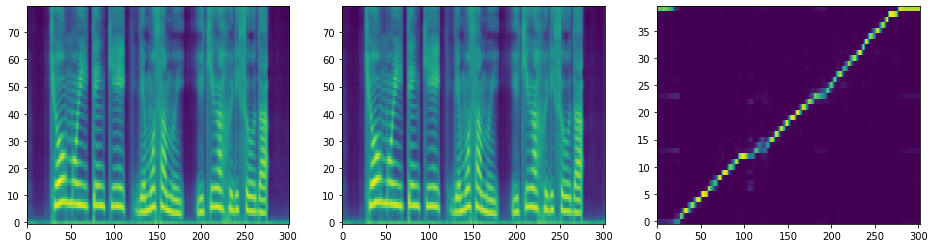

In [100]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
print(mel_outputs_postnet)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

音声を出力

In [101]:
with torch.no_grad():
  audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
  print(audio)
Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

tensor([[ 1.8573e-04,  2.6679e-04,  3.8576e-04,  ..., -5.9366e-05,
          2.9206e-06, -1.9014e-05]], device='cuda:0', dtype=torch.float16)
